## PCR Signal 판정 기계학습 모델

 + 전처리 파일 := "pcr_pre.csv"
 + Signal 존재 여부 확률 값으로 출력


In [269]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# DataFrame의 값 Line Chart 그리기
def plotData(df, columns = None, legend=None, type=None, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], 
             title=None, ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(11,3), saveto=None):
    fig = plt.figure(figsize=figsize)
    if ylim != None :
        plt.ylim(ylim[0], ylim[1])
        
    for i, col in enumerate(columns) :
        plt.plot(df[col], linewidth=1, color=color[i])
        
    # plt.grid(True, color='#f2f5f3', linestyle='-', linewidth=1)
    plt.grid(True, axis='y', color='#f2f5f3', alpha=0.5, linestyle='--')
    plt.grid(True, axis='x', color='#f2f5f3', alpha=0.5, linestyle='--')
    if title != None :
        plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12, labelpad=13) ; 
    plt.xlabel(xlabel, fontsize=12, labelpad=8)
    if legend == None :
        legend = columns
    _legend = plt.legend(legend, prop={'size': 13})
    _legend.get_frame().set_alpha(None)
    _legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    plt.autoscale(enable=True, axis='x', tight=True)
    #     plt.axhline(y=10.0, color='r', linewidth=2)
    # plt.axhline(y=9.8, linewidth=2, color='#ff0000')
    #     plt.axvline(x=datetime(2019, 1, 1), color='r', linestyle=':', linewidth=1)
    if saveto != None :
        #plt.close(fig)
        plt.savefig(saveto)
    else :
        plt.show()


In [270]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping


### 세가지 조건에 따른 Signal 확률 조합하기

In [6]:

def P_FinalMax(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Max ====================
    #-------------------------------------------  3 값 중 --> Max 값
    if _sel == 1 :
        _P = max([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])
    
    #-------------------------------------------  Ct_Rn & Rn_Last --> Max 값
    if _sel == 2 :
        _P = max([_P_Ct_Rn, _P_Rn_Last])
    
    #-------------------------------------------  Th_Ct & Rn_Last  --> Max 값
    if _sel == 3 :
        _P = max([_P_Th_Ct, _P_Rn_Last])
        
    return _P
    

    
def P_FinalMean(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Max ====================
    #-------------------------------------------  전체  평균 값
    if _sel == 1 :
        _P = np.mean([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])

    #-------------------------------------------  Ct_Rn & Rn_Last  평균 값
    if _sel == 2 :
        _P = np.mean([_P_Ct_Rn, _P_Rn_Last])

    #-------------------------------------------  Th_Ct & Rn_Last  평균 값
    if _sel == 3 :
        _P = np.mean([_P_Th_Ct, _P_Rn_Last])
        
    return np.round(_P, 2)

        
def P_FinalOX(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Digital : O or 1 ====================
    #-------------------------------------------  3 값 중 하나만 0.5 이상이면
    if _sel == 1 :
        _P = max([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0
    
    #-------------------------------------------  Ct_Rn or Rn_Last  > 0.5
    if _sel == 2 :
        _P = max([_P_Ct_Rn, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0
    
    #-------------------------------------------  Th_Ct or Rn_Last  > 0.5
    if _sel == 3 :
        _P = max([_P_Th_Ct, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0

    #-------------------------------------------  기존 방식 Ct_Rn 값 만으로.....
    if _sel == 4 :
        if _P_Ct_Rn >= 0.5 :
            return 1
        else :
            return 0


### + Loading "pcr_pre.csv"

In [263]:
filename_pre = "pcr_pre.csv"
df_pre = pd.read_csv(filename_pre, encoding='euckr')
# df_pre.dtypes

# 모델 생성 및 Training : 제1안
 + Train-X := 40개의 dRn 값
 + Train-Y := P_Ct_Rn 값 (기준 Ct Cycle에서의 dRn 값이 Threshold 초과 여부 판단)

In [136]:
# ----------------------------------------------- 학습 데이터 X, Y 준비
def prepareTrainXY(df):  #------------- X = Rn-1 ~ Rn-40, Y = P_FinalOX
    _cols = [ f'{i}' for i in range(1, 41)]
    X = df[_cols].values
    Y = df['P_Ct_Rn'].values
    
    return np.array(X), np.array(Y)


#---------------------------------------------------------------------- 학습 History Plot
def drawHistory(history):
    ## summarize history for loss
    plt.figure(figsize=(14,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.plot(history.history['mae'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()    
    return
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



In [132]:
#---------------------------------------------------------------------- 모델 생성
def createModelMLP(input_dim=1, loss='mse', optimizer='adam', metrics=['accuracy']):
    model = keras.Sequential()

    model.add(layers.Dense(100, activation="relu", input_shape=[input_dim])) # input_dim=input_dim)) # 
    # model.add(Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) # binary_crossentropy
    return model


#---------------------------------------------------------------------- 모델 학습하기
def fitModel(model, X, Y, v_split=0.2, epochs=50, batch_size=20, f_callback = True, es_monitor='val_accuracy', es_patience=20):
    if f_callback :
        es = EarlyStopping(monitor=es_monitor, mode='auto', verbose=1, patience=es_patience)  # to overcome over-fitting
                                                                                  # 매 batch마다 Update --> Loss 계산 변화 점검
                                                                                  # epoch당 600번 update 중 100번 동안 변화 없으면 중지
        history = model.fit(X, Y, validation_split=v_split, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])
    else :
        history = model.fit(X, Y, validation_split=v_split, epochs=epochs, batch_size=batch_size, verbose=2)

    return history
 

Epoch 1/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0895 - mae: 0.2416 - msle: 0.0566 - val_loss: 0.0383 - val_mae: 0.1403 - val_msle: 0.0269
Epoch 2/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0287 - mae: 0.1224 - msle: 0.0206 - val_loss: 0.0176 - val_mae: 0.0937 - val_msle: 0.0129
Epoch 3/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0135 - mae: 0.0841 - msle: 0.0100 - val_loss: 0.0099 - val_mae: 0.0709 - val_msle: 0.0072
Epoch 4/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0074 - mae: 0.0635 - msle: 0.0055 - val_loss: 0.0062 - val_mae: 0.0565 - val_msle: 0.0045
Epoch 5/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0044 - mae: 0.0495 - msle: 0.0033 - val_loss: 0.0044 - val_mae: 0.0473 - val_msle: 0.0032
Epoch 6/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0031 - mae: 0.0411 - msle: 0.0023 - val_loss: 0.0035 - val_mae: 0.0415 - val_msle: 0.0025
Epoch 7/50
62/62

62/62 [==============================] - 0s 1ms/step - loss: 1.3470e-04 - mae: 0.0086 - msle: 8.8442e-05 - val_loss: 2.3500e-04 - val_mae: 0.0102 - val_msle: 1.3684e-04
Epoch 48/50
62/62 [==============================] - 0s 1ms/step - loss: 1.5392e-04 - mae: 0.0092 - msle: 9.5749e-05 - val_loss: 2.2394e-04 - val_mae: 0.0101 - val_msle: 1.3851e-04
Epoch 49/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3464e-04 - mae: 0.0086 - msle: 8.5845e-05 - val_loss: 2.2131e-04 - val_mae: 0.0101 - val_msle: 1.2905e-04
Epoch 50/50
62/62 [==============================] - 0s 1ms/step - loss: 1.2449e-04 - mae: 0.0083 - msle: 8.0644e-05 - val_loss: 2.1169e-04 - val_mae: 0.0099 - val_msle: 1.2903e-04


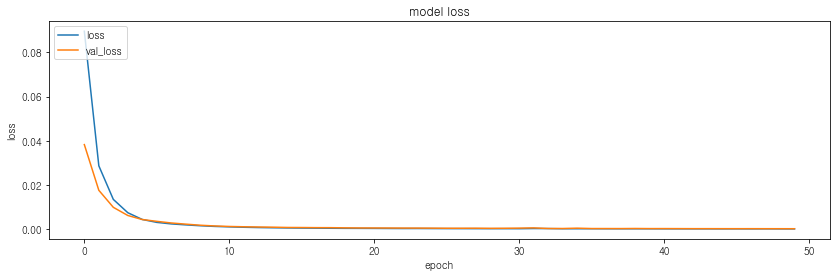

In [194]:
X, Y = prepareTrainXY(df_pre)
model = createModelMLP(input_dim =len(X[0]), loss='mse', metrics=['mae', 'msle'])
history = fitModel(model, X, Y, epochs=50, batch_size=20, es_monitor='loss', es_patience=10)
drawHistory(history)
model.save('pcr_model_1.h5')

In [144]:
loss, mae, mse = model.evaluate(X, Y, verbose=2)

48/48 - 0s - loss: 4.6137e-04 - mae: 0.0107 - msle: 3.5769e-04


In [145]:
df_pre['P_Ct_Rn_pred'] = model.predict(X)
df_pre[['P_Ct_Rn_pred', 'P_Ct_Rn', 'P_Final_Mean']]

,P_Ct_Rn_pred,P_Ct_Rn,P_Final_Mean
0,0.999026,1.0,0.95
1,0.996231,1.0,0.87
2,0.004282,0.0,0.00
3,0.000939,0.0,0.00
4,0.013587,0.0,0.00
...,...,...,...
1531,0.008318,0.0,0.00
1532,0.000003,0.0,0.00
1533,0.999994,1.0,0.93
1534,0.000044,0.0,0.00


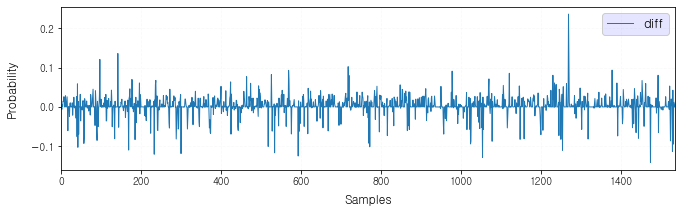

,Target,diff,P_Ct_Rn_pred,P_Ct_Rn
1268,F4-1,0.235843,0.735843,0.5


In [158]:
df_pre['diff'] = df_pre['P_Ct_Rn_pred'] - df_pre['P_Ct_Rn']
plotData(df_pre, columns=['diff'], ylabel='Probability', xlabel='Samples', ylim=None, figsize=(11,3))
df_diff = df_pre[df_pre['diff'] >= 0.15]
df_diff[['Target', 'diff', 'P_Ct_Rn_pred', 'P_Ct_Rn']]

# 모델 생성 및 Training : 제2안
 + Train-X := 40개의 dRn 값
 + Train-Y := P_Ct_Rn, P_Th_Ct, P_Rn_Last 3종 확률 동시 출력

In [242]:
# ----------------------------------------------- 학습 데이터 X, Y 준비
def prepareTrainXY(df):  #------------- X = Rn-1 ~ Rn-40, Y = P_FinalOX
    _cols = [ f'{i}' for i in range(1, 41)]
    X = df[_cols].values
    Y = df[['P_Ct_Rn', 'P_Th_Ct', 'P_Rn_Last', ]].values
    
    return np.array(X), np.array(Y)

#---------------------------------------------------------------------- 모델 생성
def createModelMLP(input_dim=1, output_dim = 3, loss='mse', optimizer='adam', metrics=['accuracy']):
    model = keras.Sequential()

    model.add(layers.Dense(100, activation="relu", input_shape=[input_dim])) # input_dim=input_dim)) # 
    # model.add(Dense(64, activation="relu"))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) # binary_crossentropy
    return model



Epoch 1/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0979 - mae: 0.2622 - msle: 0.0637 - val_loss: 0.0559 - val_mae: 0.1744 - val_msle: 0.0377
Epoch 2/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0411 - mae: 0.1463 - msle: 0.0284 - val_loss: 0.0296 - val_mae: 0.1122 - val_msle: 0.0199
Epoch 3/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0213 - mae: 0.0972 - msle: 0.0149 - val_loss: 0.0193 - val_mae: 0.0810 - val_msle: 0.0123
Epoch 4/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0134 - mae: 0.0714 - msle: 0.0090 - val_loss: 0.0152 - val_mae: 0.0654 - val_msle: 0.0091
Epoch 5/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0099 - mae: 0.0583 - msle: 0.0063 - val_loss: 0.0133 - val_mae: 0.0568 - val_msle: 0.0075
Epoch 6/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0079 - mae: 0.0495 - msle: 0.0048 - val_loss: 0.0121 - val_mae: 0.0508 - val_msle: 0.0066
Epoch 7/50
62/62

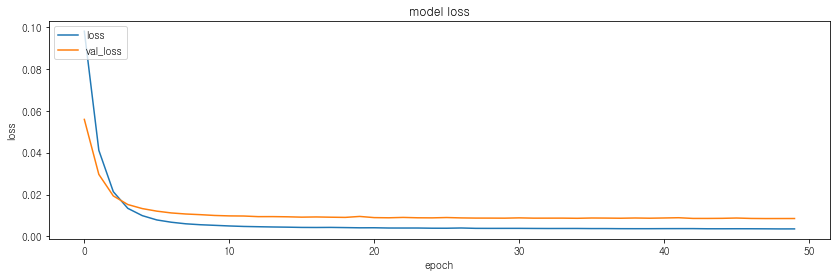

In [243]:
X, Y = prepareTrainXY(df_pre)
model = createModelMLP(input_dim =len(X[0]), loss='mse', metrics=['mae', 'msle'])
history = fitModel(model, X, Y, epochs=50, batch_size=20, es_monitor='loss', es_patience=10)
drawHistory(history)
model.save('pcr_model_2.h5')

In [156]:
loss, mae, mse = model.evaluate(X, Y, verbose=2)

48/48 - 0s - loss: 0.0046 - mae: 0.0178 - msle: 0.0023


In [171]:
pred = model.predict(X)
df_pred = pd.DataFrame(np.round(pred, 2), columns=['Pred_Ct_Rn', 'Pred_Th_Ct', 'Pred_Rn_Last'])
df_pred['P_Ct_Rn'] = df_pre['P_Ct_Rn']
df_pred['P_Th_Ct'] = df_pre['P_Th_Ct']
df_pred['P_Rn_Last'] = df_pre['P_Rn_Last']
df_pred

,Pred_Ct_Rn,Pred_Th_Ct,Pred_Rn_Last,P_Ct_Rn,P_Th_Ct,P_Rn_Last
0,1.00,0.87,0.95,1.0,0.88,0.96
1,0.99,0.78,0.88,1.0,0.80,0.80
2,0.01,0.00,0.00,0.0,0.00,0.00
3,0.00,0.00,0.00,0.0,0.00,0.00
4,0.01,0.00,0.01,0.0,0.00,0.00
...,...,...,...,...,...,...
1531,0.01,0.01,0.01,0.0,0.00,0.00
1532,0.00,0.00,0.00,0.0,0.00,0.00
1533,1.00,0.79,1.00,1.0,0.80,1.00
1534,0.00,0.00,0.00,0.0,0.00,0.00


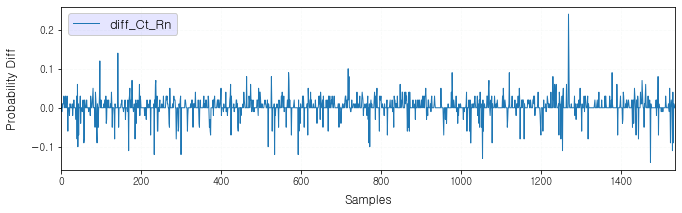

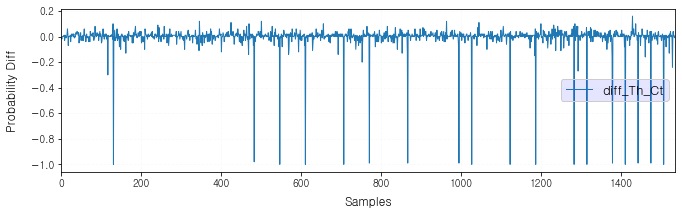

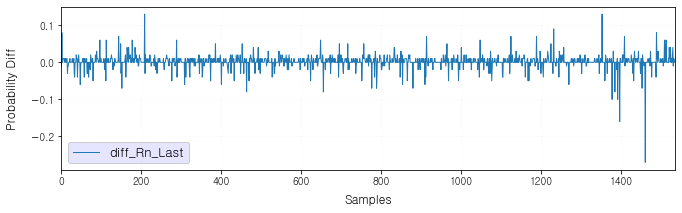

In [174]:
df_pred['diff_Ct_Rn'] = df_pred['Pred_Ct_Rn'] - df_pred['P_Ct_Rn']
df_pred['diff_Th_Ct'] = df_pred['Pred_Th_Ct'] - df_pred['P_Th_Ct']
df_pred['diff_Rn_Last'] = df_pred['Pred_Rn_Last'] - df_pred['P_Rn_Last']
plotData(df_pred, columns=['diff_Ct_Rn'], ylabel='Probability Diff', xlabel='Samples', ylim=None, figsize=(11,3))
plotData(df_pred, columns=['diff_Th_Ct'], ylabel='Probability Diff', xlabel='Samples', ylim=None, figsize=(11,3))
plotData(df_pred, columns=['diff_Rn_Last'], ylabel='Probability Diff', xlabel='Samples', ylim=None, figsize=(11,3))
# df_diff[['Target', 'diff', 'P_Ct_Rn_pred', 'P_Ct_Rn']]

In [178]:
df_pred[np.abs(df_pred['diff_Ct_Rn']) >= 0.2]

,Pred_Ct_Rn,Pred_Th_Ct,Pred_Rn_Last,P_Ct_Rn,P_Th_Ct,P_Rn_Last,diff_Ct_Rn,diff_Th_Ct,diff_Rn_Last
1268,0.74,0.73,0.87,0.5,0.72,0.88,0.24,0.01,-0.01


In [180]:
df_pred[np.abs(df_pred['diff_Th_Ct']) >= 0.2]

,Pred_Ct_Rn,Pred_Th_Ct,Pred_Rn_Last,P_Ct_Rn,P_Th_Ct,P_Rn_Last,diff_Ct_Rn,diff_Th_Ct,diff_Rn_Last
116,0.73,0.70,1.00,0.72,1.00,1.00,0.01,-0.30,0.00
130,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00
482,0.02,0.02,0.01,0.03,1.00,0.00,-0.01,-0.98,0.01
546,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00
610,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00
706,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00
770,0.01,0.01,0.01,0.00,1.00,0.00,0.01,-0.99,0.01
866,0.01,0.01,0.00,0.00,1.00,0.00,0.01,-0.99,0.00
994,0.01,0.01,0.00,0.00,1.00,0.00,0.01,-0.99,0.00
1026,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00


In [179]:
df_pred[np.abs(df_pred['diff_Rn_Last']) >= 0.2]

,Pred_Ct_Rn,Pred_Th_Ct,Pred_Rn_Last,P_Ct_Rn,P_Th_Ct,P_Rn_Last,diff_Ct_Rn,diff_Th_Ct,diff_Rn_Last
1460,0.03,0.02,0.23,0.0,0.18,0.5,0.03,-0.16,-0.27


# 모델 생성 및 Training : 제3안
 + Train-X := 40개의 dRn + P_Ct_Rn, P_Th_Ct, P_Rn_Last
 + Train-Y := P_Final_Mean

In [186]:
# ----------------------------------------------- 학습 데이터 X, Y 준비
def prepareTrainXY(df):  #------------- X = Rn-1 ~ Rn-40, Y = P_FinalOX
    _cols = [ f'{i}' for i in range(1, 41)]
    _cols = _cols + ['P_Ct_Rn', 'P_Th_Ct', 'P_Rn_Last']
    X = df[_cols].values
    Y = df['P_Final_Mean'].values
    
    return np.array(X), np.array(Y)

#---------------------------------------------------------------------- 모델 생성
def createModelMLP(input_dim=1, output_dim = 1, loss='mse', optimizer='adam', metrics=['accuracy']):
    model = keras.Sequential()

    model.add(layers.Dense(100, activation="relu", input_shape=[input_dim])) # input_dim=input_dim)) # 
    # model.add(Dense(64, activation="relu"))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) # binary_crossentropy
    return model



Epoch 1/50
62/62 [==============================] - 0s 7ms/step - loss: 0.0706 - mae: 0.2088 - msle: 0.0470 - val_loss: 0.0339 - val_mae: 0.1294 - val_msle: 0.0241
Epoch 2/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0249 - mae: 0.1133 - msle: 0.0180 - val_loss: 0.0152 - val_mae: 0.0877 - val_msle: 0.0112
Epoch 3/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0113 - mae: 0.0773 - msle: 0.0084 - val_loss: 0.0083 - val_mae: 0.0649 - val_msle: 0.0061
Epoch 4/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0062 - mae: 0.0570 - msle: 0.0046 - val_loss: 0.0053 - val_mae: 0.0509 - val_msle: 0.0039
Epoch 5/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0039 - mae: 0.0456 - msle: 0.0029 - val_loss: 0.0041 - val_mae: 0.0444 - val_msle: 0.0030
Epoch 6/50
62/62 [==============================] - 0s 1ms/step - loss: 0.0028 - mae: 0.0388 - msle: 0.0021 - val_loss: 0.0034 - val_mae: 0.0396 - val_msle: 0.0024
Epoch 7/50
62/62

Epoch 47/50
62/62 [==============================] - 0s 1ms/step - loss: 1.5267e-04 - mae: 0.0091 - msle: 9.7081e-05 - val_loss: 2.0210e-04 - val_mae: 0.0098 - val_msle: 1.3153e-04
Epoch 48/50
62/62 [==============================] - 0s 1ms/step - loss: 1.4911e-04 - mae: 0.0090 - msle: 9.3471e-05 - val_loss: 1.8718e-04 - val_mae: 0.0093 - val_msle: 1.1960e-04
Epoch 49/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3002e-04 - mae: 0.0083 - msle: 8.5297e-05 - val_loss: 1.8717e-04 - val_mae: 0.0094 - val_msle: 1.1988e-04
Epoch 50/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3908e-04 - mae: 0.0088 - msle: 8.7456e-05 - val_loss: 1.9812e-04 - val_mae: 0.0097 - val_msle: 1.2492e-04


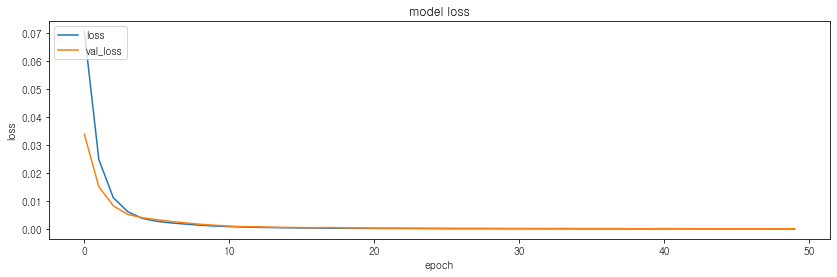

In [192]:
X, Y = prepareTrainXY(df_pre)
model = createModelMLP(input_dim =len(X[0]), loss='mse', metrics=['mae', 'msle'])
history = fitModel(model, X, Y, epochs=50, batch_size=20, es_monitor='loss', es_patience=10)
drawHistory(history)
model.save('pcr_model_3.h5')

In [188]:
loss, mae, mse = model.evaluate(X, Y, verbose=2)

48/48 - 0s - loss: 1.9033e-04 - mae: 0.0098 - msle: 1.1617e-04


In [189]:
df_pre['Pred_Final_Mean'] = model.predict(X)
df_pre[['Pred_Final_Mean', 'P_Final_Mean']]

,Pred_Final_Mean,P_Final_Mean
0,0.946704,0.95
1,0.894874,0.87
2,0.006713,0.00
3,0.003908,0.00
4,0.011399,0.00
...,...,...
1531,0.008500,0.00
1532,0.000407,0.00
1533,0.939795,0.93
1534,0.000748,0.00


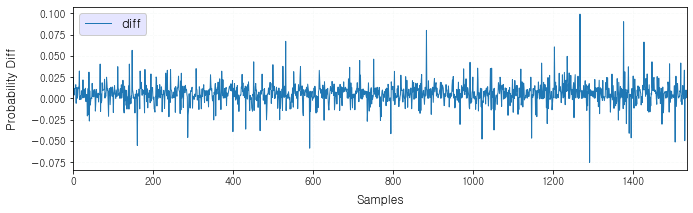

,Target,diff,P_Ct_Rn_pred,P_Ct_Rn


In [191]:
df_pre['diff'] = df_pre['Pred_Final_Mean'] - df_pre['P_Final_Mean']
plotData(df_pre, columns=['diff'], ylabel='Probability Diff', xlabel='Samples', ylim=None, figsize=(11,3))
df_diff = df_pre[df_pre['diff'] >= 0.1]
df_diff[['Target', 'diff', 'P_Ct_Rn_pred', 'P_Ct_Rn']]

# Signal 판정 모듈

In [261]:
# ----------------------------------------------- 학습 데이터 X, Y 준비
def prepareSingleX(df, line, model=1):  #------------- X = Rn-1 ~ Rn-40, Y = P_FinalOX
    
    if model == 1 :
        _cols = [ f'{i}' for i in range(1, 41)]
        X = df[_cols].loc[line].values
        Y = df.loc[line]['P_Ct_Rn']
        return np.array([X]), np.array([Y])

    if model == 2 :
        _cols = [ f'{i}' for i in range(1, 41)]
        X = df[_cols].loc[line].values
        Y = df[['P_Ct_Rn', 'P_Th_Ct', 'P_Rn_Last', ]].loc[line].values
        return np.array([X]), np.array(Y)

    if model == 3 :
        _cols = [ f'{i}' for i in range(1, 41)]
        _cols = _cols + ['P_Ct_Rn', 'P_Th_Ct', 'P_Rn_Last']
        X = df[_cols].loc[line].values
        Y = df.loc[line]['P_Final_Mean']
        return np.array([X]), np.array([Y])
    
    

models = {}
def getPCRSignal(X, model=1) :
    model_file = f"pcr_model_{model}.h5"
    
    if model_file in models :
        model = models[model_file]
    else:
        model = keras.models.load_model(model_file)
        print(f"Loading {model_file}")
        models[model_file] = model

    output = model.predict(X)
    return output



In [260]:
X, Y = prepareSingleX(df_pre, 68, model=2)

P_Signal = getPCRSignal(X, model=2)
print('추정 = ', np.round(P_Signal[0], 2), '   Expected = ', Y[0])

추정 =  [0.99 0.87 0.55]    Expected =  ['1.0' '0.88' '0.62']


In [268]:
X, Y = prepareSingleX(df_pre, 68, model=3)
print(X.shape)
P_Signal = getPCRSignal(X, model=3)
print('추정 = ', P_Signal[0][0], '   Expected = ', Y[0])

(1, 43)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [258]:
X, Y = prepareSingleX(df_pre, 68, model=1)

P_Signal = getPCRSignal(X, model=1)
print('추정 = ', P_Signal[0][0], '   Expected = ', Y[0])

Loading pcr_model_1.h5


ValueError: in user code:

    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\ProgramData\Anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected axis -1 of input shape to have value 43 but received input with shape [None, 40]
